In [2]:
from pathlib import Path
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from zoneinfo import ZoneInfo
import matplotlib.dates as mdates
import pmdarima as pm
import warnings


In [3]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (119132, 23)


In [4]:
label_col = ['travel_time_seconds']
feature_cols = [c for c in X_full.columns if c not in ['travel_time_seconds','speed','evt_duration']]
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
lag_features = ['lag1', 'lag2', 'lag3']
tmc_features = ['miles']
full_features = time_features + evt_features + lag_features + tmc_features

## ARIMA per-TMC baseline (not Pooled model)

### Fit Auto-ARIMA per TMC

In [ ]:
# Define functions for parallel ARIMAX fitting
from joblib import Parallel, delayed

def fit_single_tmc_arimax(tmc, grp, target_col='travel_time_seconds', exog_cols=None, test_frac=0.2):
    """Fit ARIMA/ARIMAX model for a single TMC."""
    grp = grp.sort_index(level='time_bin')
    n_test = int(len(grp) * test_frac)
    if len(grp) < 30:
        return (tmc, None)  # skip short series

    y_train = grp[target_col].iloc[:-n_test].values
    y_test  = grp[target_col].iloc[-n_test:].values
    X_train = grp[exog_cols].iloc[:-n_test] if exog_cols else None
    X_test  = grp[exog_cols].iloc[-n_test:] if exog_cols else None

    # Drop constant columns to avoid trend conflict
    if X_train is not None:
        X_train = X_train.loc[:, X_train.nunique() > 1]
        X_test  = X_test[X_train.columns]

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            model = pm.auto_arima(
                y_train,
                X=X_train,
                seasonal=True,
                m=24,                 # daily seasonality for hourly data
                d=0, D=0, # fixed differencing b.c. no drifts
                # ===== enable to search for best params =====
                max_p=3, max_q=3,
                max_P=2, max_Q=2,
                stepwise=True,      
                trace=True,
                # ==========================
                suppress_warnings=True 
            )
        return (tmc, (model, X_test, y_test))
    except Exception as e:
        return (tmc, None)
    
def fit_arimax_per_tmc_parallel(df, target_col='travel_time_seconds', exog_cols=None, test_frac=0.2, n_jobs=-1):
    tmc_groups = list(df.groupby(level='tmc_code'))
    print(f"Starting parallel ARIMA training on {len(tmc_groups)} segments...")

    results = Parallel(n_jobs=n_jobs, backend='loky', verbose=5)(
        delayed(fit_single_tmc_arimax)(tmc, grp, target_col, exog_cols, test_frac)
        for tmc, grp in tmc_groups
    )

    # collect results
    models = {tmc: res for tmc, res in results if res is not None}
    print(f"Completed {len(models)} successful fits out of {len(tmc_groups)}")
    return models


In [6]:
# model evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

def evaluate_arimax_models(models_dict):
    results = []
    for tmc, (model, X_test, y_test) in models_dict.items():
        try:
            # forecast same length as test
            n_periods = len(y_test)
            y_pred = model.predict(n_periods=n_periods, X=X_test)
            print(y_pred)

            rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))
            mae  = mean_absolute_error(y_test, y_pred)
            r2   = r2_score(y_test, y_pred)

            results.append({
                'tmc_code': tmc,
                'rmse': rmse,
                'mae': mae,
                'r2': r2,
                'n_obs': len(y_test)
            })

        except Exception as e:
            results.append({
                'tmc_code': tmc,
                'rmse': np.nan,
                'mae': np.nan,
                'r2': np.nan,
                'error': str(e)
            })
            continue

    results_df = pd.DataFrame(results)
    summary = results_df[['rmse', 'mae', 'r2']].agg(['mean', 'median'])
    print("=== ARIMA Model Evaluation Summary ===")
    print(summary)
    return results_df

In [15]:
# train a single arima
tmc = '115+04177'
grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
m = fit_single_tmc_arimax(tmc, grp, target_col='travel_time_seconds', exog_cols=None, test_frac=0.2)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=9.77 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-1808.014, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=6.75 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-2154.169, Time=3.19 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13121.312, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-2058.549, Time=0.15 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(0,0,1)(0,0,2)[24] intercept   : AIC=-2184.767, Time=6.95 sec
 ARIMA(0,0,1)(1,0,2)[24] intercept   : AIC=-2189.318, Time=26.68 sec
 ARIMA(0,0,1)(2,0,2)[24] intercept   : AIC=-2190.694, Time=36.15 sec
 ARIMA(0,0,1)(2,0,1)[24] intercept   : AIC=inf, Time=38.13 sec
 ARIMA(0,0,0)(2,0,2)[24] intercept   : AIC=-2003.986, Time=25.14 sec
 ARIMA(1,0,1)(2,0,2)[24] intercept   : AIC=-2211.517, Time=30.54 sec
 ARIMA(1,0,1)(1,0,2)[24] intercept   : AIC=-2135.568, Time=30.58 sec
 ARIMA(1,0,1)(2,0,1)[24

: 

In [7]:
# Visualize model prediction on each segment
# (tmc, (model, X_test, y_test))
tmc = '115+04177'
model_name = 'arima_base'
target_col = 'travel_time_seconds'

grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')

n_test = int(len(grp) * 0.2)
y_train = grp[target_col].iloc[:-n_test].values
y_test  = grp[target_col].iloc[-n_test:].values

# pred = models[model_name][tmc][0].predict(len(models[model_name][tmc][2]))
pred = m[1][0].predict(n_periods=len(m[1][2]))

plt.figure(figsize=(12,6))
plt.plot(time_series[-n_test:], y_test, label='Actual', color='blue')
plt.plot(time_series[-n_test:], pred, label='Predicted', color='orange')
plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
plt.title(f'ARIMA Model Prediction for TMC {tmc} ({model_name})')
plt.xlabel('Time')
plt.ylabel('Travel Time (seconds)')
plt.legend()
plt.show()

NameError: name 'm' is not defined

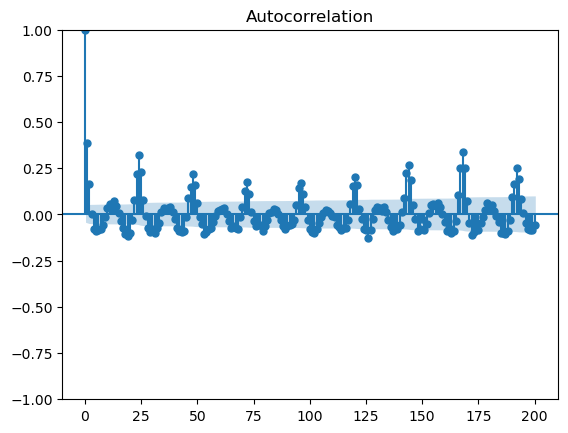

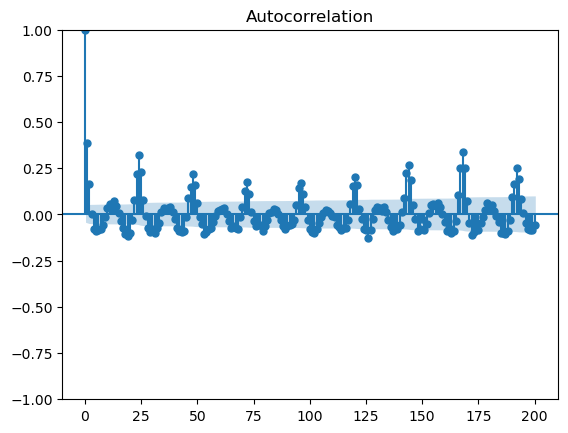

In [ ]:
# autocorrelation function (ACF) of your training series (y_train), up to 200 lags (hours).
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y_train, lags=200)

In [40]:
m[1][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1907
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1058.621
Date:                Wed, 08 Oct 2025   AIC                          -2111.243
Time:                        20:40:02   BIC                          -2094.583
Sample:                             0   HQIC                         -2105.111
                               - 1907                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.6421      0.059     78.103      0.000       4.526       4.759
ar.L1          0.3846      0.008     50.324      0.000       0.370       0.400
sigma2         0.0193      0.000    141.886      0.000       0.019       0.020
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):            332546.03
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             4.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        67.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
models = {
    'arima_base': fit_arimax_per_tmc_parallel(X_full, exog_cols=None),
    'arima_evt':  fit_arimax_per_tmc_parallel(X_full, exog_cols=['evt_total','hour_sin','hour_cos','dow_sin','dow_cos']),
}

for name, arima_models in models.items():
    print(f"Evaluating model: {name}")
    results_df = evaluate_arimax_models(arima_models)

In [19]:
# Save trained models
import joblib
joblib.dump(models, '../models/arima_models.pkl')

['../models/arima_models.pkl']